The following notebook illustrates how to manipulate the data generated by

1. Dave Paul's scripts that extract the Intel DCT data from all of the NVMe devices across the Cori burst buffer, and
2. my atgtools/parse_dct_stats.py script that munges the data produced by Dave's scripts

It creates a set of DataFrames that aggregate NVMe device data on a per-node basis to simplify the process of determining how different metrics vary within nodes and between nodes.

In [1]:
import pandas
import json
import numpy as np

In [2]:
%matplotlib inline

In [6]:
### Load the dataframe generated by atgtools/parse_dct_stats.py
df = pandas.DataFrame.from_csv('isdct_raw.csv')
df.head()

NodeName  AvailableSpare  AverageNandEraseCycles  \
DeviceID                                                                 
CVF8527500094P0DGN-1  nid08849             100                      54   
CVF8527500094P0DGN-2  nid08849             100                      54   
CVF85275000L4P0DGN-1  nid06669             100                      45   
CVF85275000L4P0DGN-2  nid06669             100                      45   
CVF85275000W4P0DGN-1  nid03089             100                      42   

                      CRC_Error_Count_Raw  ControllerBusyTime  CrcErrorCount  \
DeviceID                                                                       
CVF8527500094P0DGN-1                    0                  58              0   
CVF8527500094P0DGN-2                    0                  59              0   
CVF85275000L4P0DGN-1                    0                  49              0   
CVF85275000L4P0DGN-2                    0                  24              0   
CVF85275000W4P0DGN-1                    0                  30              0   

                      DataUnitsRead  DataUnitsWritten  EraseFailCount  \
DeviceID                                                                
CVF8527500094P0DGN-1       69916586         100913652               0   
CVF8527500094P0DGN-2       69919677         100926394               0   
CVF85275000L4P0DGN-1       37006064          60705043               0   
CVF85275000L4P0DGN-2       37009804          60703560               0   
CVF85275000W4P0DGN-1       41719176          72204819               0   

                      Erase_Fail_Count_Raw           ...             \
DeviceID                                             ...              
CVF8527500094P0DGN-1                     0           ...              
CVF8527500094P0DGN-2                     0           ...              
CVF85275000L4P0DGN-1                     0           ...              
CVF85275000L4P0DGN-2                     0           ...              
CVF85275000W4P0DGN-1                     0           ...              

                      SMBusAddress  Temperature  Timed_Workload_Timer_Raw  \
DeviceID                                                                    
CVF8527500094P0DGN-1           106           32                    983264   
CVF8527500094P0DGN-2           107           31                    983258   
CVF85275000L4P0DGN-1           106           29                    982913   
CVF85275000L4P0DGN-2           107           29                    982903   
CVF85275000W4P0DGN-1           106           31                    982271   

                      Timed_Workload__Host_Read/Write_Ratio_Raw  \
DeviceID                                                          
CVF8527500094P0DGN-1                                         40   
CVF8527500094P0DGN-2                                         40   
CVF85275000L4P0DGN-1                                         37   
CVF85275000L4P0DGN-2                                         37   
CVF85275000W4P0DGN-1                                         36   

                      Timed_Workload__Media_Wear_Raw  UnsafeShutdowns  \
DeviceID                                                                
CVF8527500094P0DGN-1                             174               31   
CVF8527500094P0DGN-2                             174               31   
CVF85275000L4P0DGN-1                             153               31   
CVF85275000L4P0DGN-2                             153               31   
CVF85275000W4P0DGN-1                             133               31   

                      Wear_Leveling_Count_AverageEraseCycles  \
DeviceID                                                       
CVF8527500094P0DGN-1                                      54   
CVF8527500094P0DGN-2                                      54   
CVF85275000L4P0DGN-1                                      45   
CVF85275000L4P0DGN-2                                      45   
CVF85275000W4P0DGN-1      

In [8]:
### Create a new dataframe of per-node data
df_precursor = {}
for i, row in df.iterrows():
    node = row['NodeName']
    #df.index.get_loc(result.iloc[0].name)
    ssd_idx = row.index
    if node not in df_precursor:
        df_precursor[node] = {}
    df_precursor[node]["%s_TiB_%s" % ('DataUnitsRead', ssd_idx)] = row['DataUnitsRead']*1000.0*512/2**40
    df_precursor[node]["%s_TiB_%s" % ('DataUnitsWritten', ssd_idx)] = row['DataUnitsWritten']*1000.0*512/2**40
    df_precursor[node]["%s_%s" % ('WAF', ssd_idx)] = float(row['NAND_Bytes_Written_Raw'])/row['Host_Bytes_Written_Raw']
    
per_node_rw = pandas.DataFrame.from_dict( df_precursor, orient='index')

In [9]:
### Add per-node aggregate statistics -- initialize new rows
for key in [ 'DataUnitsRead_TiB', 'DataUnitsWritten_TiB', 'WAF' ]:
    for metric in [ 'Avg', 'StDev', 'CV' ]:
        per_node_rw["%s_%s" % (key, metric)] = np.nan

### Add per-node aggregate statistics -- calculate aggregate metrics
for _, row in per_node_rw.iterrows():
    for key in [ 'DataUnitsRead_TiB', 'DataUnitsWritten_TiB', 'WAF' ]:
        data_array = np.array([ row['%s_%d' % (key, j)] for j in range(4)])
        row[key+'_Avg'] = np.mean( data_array )
        row[key+'_StDev'] = np.std( data_array )
        row[key+'_CV'] = row[key+'_StDev'] / row[key+'_Avg']

KeyError: 'DataUnitsRead_TiB_0'

In [98]:
### Sort the DataFrame
per_node_rw = per_node_rw[sorted(per_node_rw.keys())]

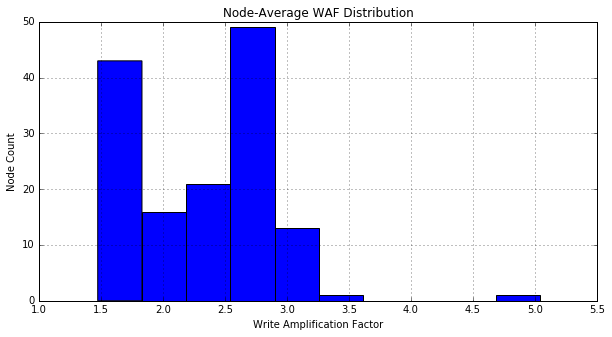

In [120]:
### Plot the WAF distribution directly from the DataFrame
axs = per_node_rw.hist(column='WAF_Avg', figsize=(10,5))
axs[0,0].set_xlabel("Write Amplification Factor")
axs[0,0].set_ylabel("Node Count")
axs[0,0].set_title("Node-Average WAF Distribution")